#Pneumonia Diagnosing 

### Summary
#### Steps of creating a world-class Image Classifier:

    1. Import data
       data = ImageDataBunch.from_name_re(...)
       
    2. Build model
           learn = create_cnn(...)
           
    3. Unfreeze model
        learn.unfreeze(...)
        
    4. Find good learning rate(s)
        learn.lr_find(...)
        
    5. Train model again
         learn.fit_one_cycle(...)
         
    6. Analyze the results
        ClassificationInterpretation.from_learner(...)

In [0]:
import os
from fastai.vision import *
from fastai.metrics import accuracy

## Data Preparation

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 1.14G/1.15G [00:10<00:00, 140MB/s]
100% 1.15G/1.15G [00:10<00:00, 114MB/s]


In [0]:
!ls 

chest-xray-pneumonia.zip  kaggle.json  sample_data


In [0]:
!unzip chest-xray-pneumonia.zip

Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          


In [0]:
!unzip chest_xray.zip

In [0]:
path = Path('chest_xray')

In [0]:
path.ls()

[PosixPath('chest_xray/test'),
 PosixPath('chest_xray/val'),
 PosixPath('chest_xray/train'),
 PosixPath('chest_xray/.DS_Store')]

In [0]:
get_image_files(path/'train/NORMAL')[:5]

[PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1203-0001.jpeg'),
 PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1310-0001.jpeg'),
 PosixPath('chest_xray/train/NORMAL/IM-0309-0001.jpeg'),
 PosixPath('chest_xray/train/NORMAL/IM-0727-0001.jpeg'),
 PosixPath('chest_xray/train/NORMAL/IM-0439-0001.jpeg')]

In [0]:
bs = 64  #batch size
size = 224 #image size
#num_workers = 0

In [0]:
data = (ImageItemList.from_folder(path)
  .split_by_folder(train='train', valid='test')
  .label_from_folder()
  .transform(get_transforms(),size=size)
  .databunch(bs=bs)
  .normalize(imagenet_stats))
  
  

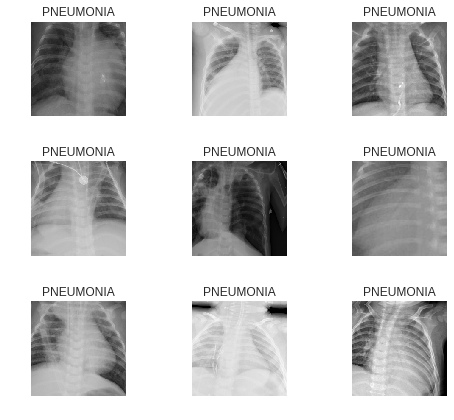

In [0]:
data.show_batch(rows=3, figsize=(7,6))  #random show for samples

In [0]:
print(data.classes)
print(data.c)

['NORMAL', 'PNEUMONIA']
2


## Model Training

*   **Bottleneck training**



In [0]:
learn = create_cnn(data,models.vgg19_bn,metrics=accuracy)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.torch/models/vgg19_bn-c79401a0.pth
574769405it [00:06, 85173050.62it/s]


In [0]:
learn.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [0]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy
1,0.283794,0.370939,0.873397
2,0.181013,0.327138,0.881410
3,0.154565,0.321571,0.886218


In [0]:
learn.save('stage-1')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)

True

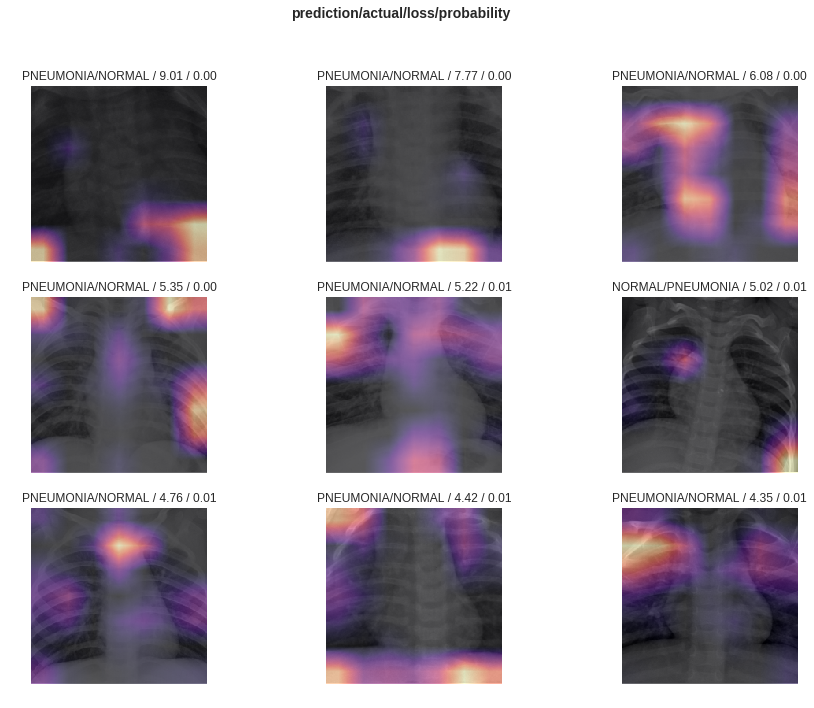

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)


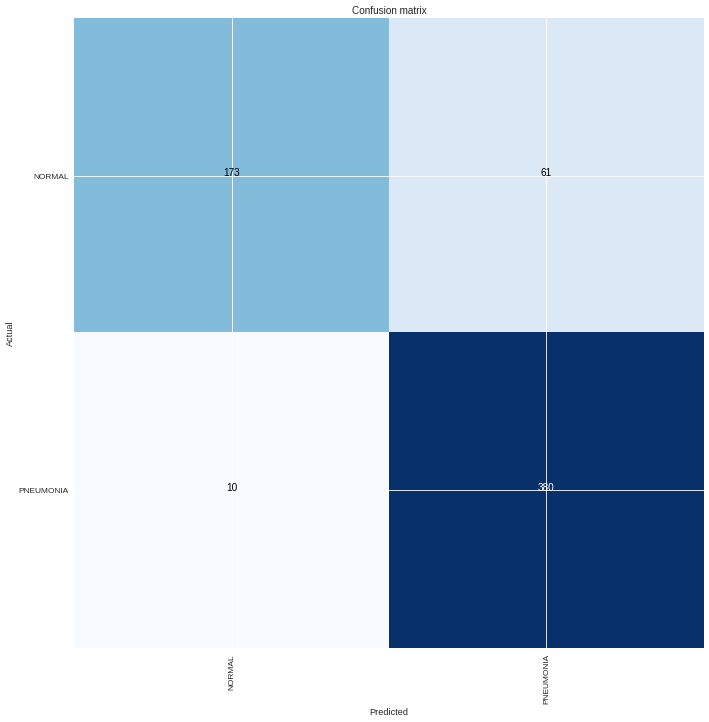

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [0]:
interp.most_confused(min_val=2)

[('NORMAL', 'PNEUMONIA', 61), ('PNEUMONIA', 'NORMAL', 10)]

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-06


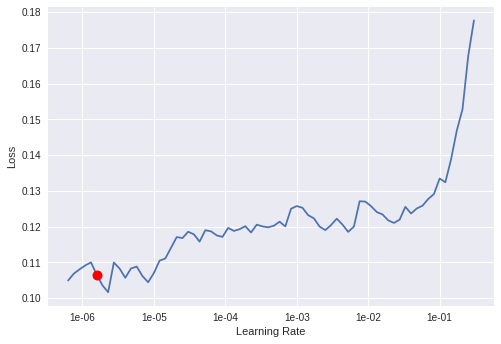

In [0]:
learn.recorder.plot()

*  ** Whole network training**



In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-5))

epoch,train_loss,valid_loss,accuracy
1,0.119113,0.311106,0.887821
2,0.118348,0.308229,0.887821


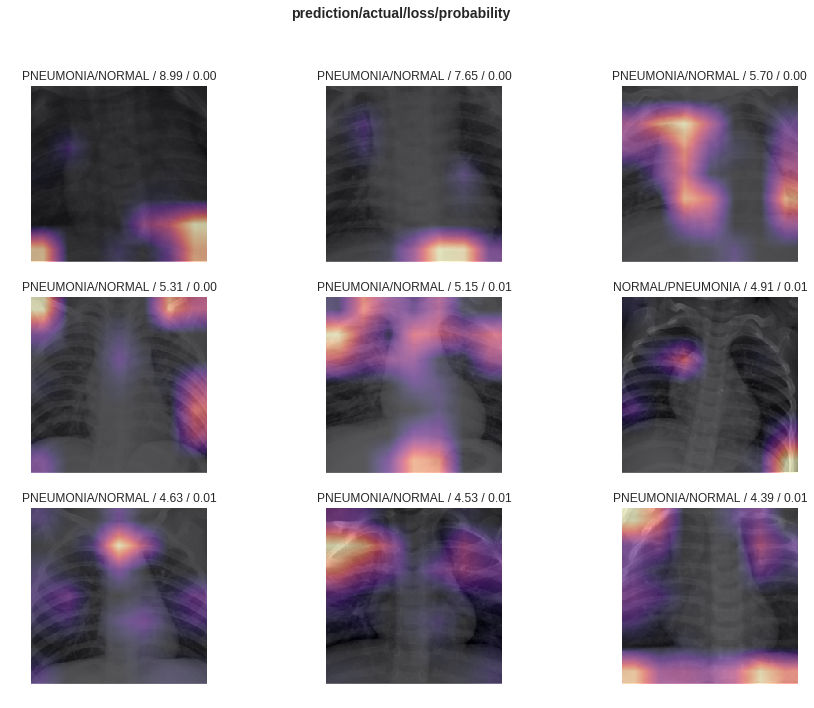

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds) == len(losses) == len(idxs)
interp.plot_top_losses(9, figsize=(15,11))

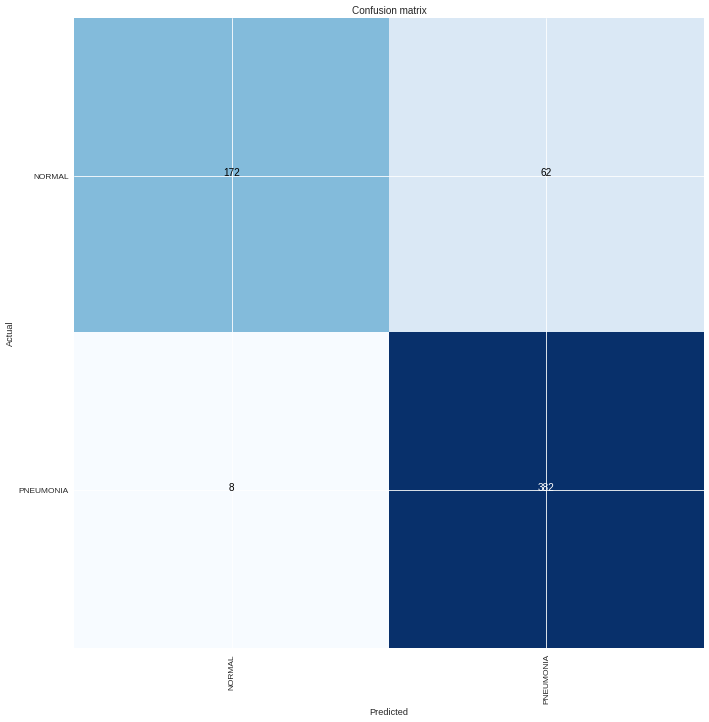

In [0]:
doc(interp.plot_top_losses)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)


In [0]:
interp.most_confused(min_val=2)

[('NORMAL', 'PNEUMONIA', 62), ('PNEUMONIA', 'NORMAL', 8)]